In [1]:
import pandas as pd
import xgboost as xgb  
import numpy as np
from numpy import sort
from pprint import pprint
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import log_loss
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import zipfile
import pickle

/usr/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
tr=pd.read_csv('../data/train_new.csv')
te=pd.read_csv('../data/test_new.csv')
trte=pd.concat([tr,te]).reset_index(drop=True)

In [ ]:
trte = pd.concat([tr_raw,te_raw]).reset_index(drop=True)
trte['d']=trte.starttime.map(lambda x: int(str(x)[8:10]))
trte.loc[trte.d==1, 'd'] = 32
trte['wd']=trte.d.map(lambda x: int(x%7+1))
trte['h']=trte.starttime.map(lambda x: int(str(x)[11:13]))
trte['m']=trte.starttime.map(lambda x: int(str(x)[14:16]))
trte=trte.drop('starttime', axis=1)
tr=trte[:len(tr)]
te=trte[len(tr):]
tr_new.to_csv('../data/train_new.csv', index=None)
te_new.to_csv('../data/test_new.csv', index=None)

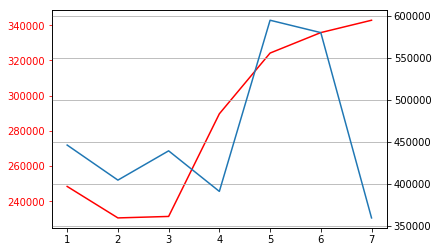

In [4]:
key = 'wd'
s = te.groupby(key).apply(lambda df: len(df))
ss = tr.groupby(key).apply(lambda df: len(df))

fig,ax1 = plt.subplots()
ax1.plot(s.index, s.values, 'r')
ax1.tick_params('y', colors='r')
ax1.xaxis.set_ticks(s.index)
ax2 = ax1.twinx()
ax2.plot(s.index, ss.values)
plt.grid()
plt.show()

In [5]:
te.head()

,orderid,userid,bikeid,biketype,geohashed_start_loc,geohashed_end_loc,d,wd,h,m
0,86458,467987,13488,1,wx4gfbe,NaN,27,7,19,19
1,1473189,976462,170537,2,wx4eqep,NaN,31,4,17,45
2,1441027,790813,167447,2,wx4e5zr,NaN,26,6,11,31
3,4747983,744823,472963,1,wx4dxz4,NaN,31,4,18,30
4,43984,712391,7158,1,wx4ewq5,NaN,25,5,12,46


In [23]:
user = tr.groupby('geohashed_start_loc').apply(lambda df: str(len(df))+str(df.geohashed_end_loc.values))

In [28]:
len(tr.geohashed_end_loc.unique())

85828

In [5]:
uid_tr = tr.d.unique()
uid_te = te.d.unique()

In [6]:
len(uid_tr),len(uid_te)

(14, 8)

In [7]:
sorted(uid_tr), sorted(uid_te)

([10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24],
 [25, 26, 27, 28, 29, 30, 31, 32])

In [18]:
len(set(uid_tr).intersection(uid_te))

256628

In [8]:
tr.head()

,orderid,userid,bikeid,biketype,geohashed_start_loc,geohashed_end_loc,d,wd,h,m
0,1893973,451147,210617,2,wx4snhx,wx4snhj,14,1,22,16
1,4657992,1061133,465394,1,wx4dr59,wx4dquz,14,1,22,16
2,2965085,549189,310572,1,wx4fgur,wx4fu5n,14,1,22,16
3,4548579,489720,456688,1,wx4d5r5,wx4d5r4,14,1,22,16
4,3936364,467449,403224,1,wx4g27p,wx4g266,14,1,22,16


In [19]:
v1='wx4g559'
v2='geohashed_start_loc'
te.loc[te[v2]==v1]

,orderid,userid,bikeid,biketype,geohashed_start_loc,geohashed_end_loc,d,wd,h,m
2319,894422,581065,116731,2,wx4g559,NaN,26,6,8,41
6337,272233,940390,38366,1,wx4g559,NaN,25,5,21,0
7970,1296145,962873,153876,2,wx4g559,NaN,27,7,8,14
10435,1953608,656902,216190,2,wx4g559,NaN,25,5,13,57
11019,3404857,742473,351998,1,wx4g559,NaN,27,7,8,48
12775,3563650,570050,367287,1,wx4g559,NaN,31,4,17,55
14004,1087173,293124,134712,2,wx4g559,NaN,26,6,18,25
16256,3007899,870834,314697,1,wx4g559,NaN,25,5,11,38
17186,2007522,428437,221225,2,wx4g559,NaN,28,1,11,13
17901,3981868,735709,407458,1,wx4g559,NaN,27,7,6,49


In [20]:
tr.loc[tr[v2]==v1]

,orderid,userid,bikeid,biketype,geohashed_start_loc,geohashed_end_loc,d,wd,h,m
2465,5039415,549761,495930,1,wx4g559,wx4g54u,14,1,22,38
4786,5062115,411399,498046,1,wx4g559,wx4g54s,14,1,23,10
7872,748763,580430,99355,1,wx4g559,wx4g4fm,16,3,10,19
9650,2172175,821919,236776,2,wx4g559,wx4g4fm,16,3,10,29
12177,3690339,200023,379536,1,wx4g559,wx4g51v,16,3,10,44
14920,3248662,469752,337318,1,wx4g559,wx4g4fq,16,3,18,1
15557,742322,964940,98563,1,wx4g559,wx4g54x,16,3,18,2
16088,3820736,907944,392078,1,wx4g559,wx4g4fj,16,3,18,3
16247,2323856,917298,251159,2,wx4g559,wx4g4fr,16,3,18,4
17674,1525298,134014,175412,2,wx4g559,wx4g4fz,16,3,18,6


In [23]:
trte_ = trte.loc[['orderid', 'userid', 'bikeid', 'biketype', 'geohashed_start_loc',
       'geohashed_end_loc']].apply(LabelEncoder().fit_transform)

orderid                False
userid                 False
bikeid                 False
biketype                True
geohashed_start_loc     True
geohashed_end_loc       True
d                       True
wd                      True
h                      False
m                      False
dtype: bool

In [24]:
trte.columns.values

array(['orderid', 'userid', 'bikeid', 'biketype', 'geohashed_start_loc',
       'geohashed_end_loc', 'd', 'wd', 'h', 'm'], dtype=object)

In [41]:
locs = np.concatenate([tr.geohashed_start_loc.values, tr.geohashed_end_loc.values, te.geohashed_start_loc.values])
le = LabelEncoder()
locs_le = le.fit_transform(locs)

In [26]:
tr.geohashed_start_loc.values

array(['wx4snhx', 'wx4dr59', 'wx4fgur', ..., 'wx4fbyv', 'wx4u11d',
       'wx4f6tk'], dtype=object)

In [33]:
locs_le.shape

(8431188,)

In [30]:
locs

array(['wx4snhx', 'wx4dr59', 'wx4fgur', ..., 'wx4smz6', 'wx542kb',
       'wx4cfb0'], dtype=object)

In [7]:
le_.inverse_transform([1])

array(['w7w3zs5'], dtype=object)

In [39]:
max(locs_le)

110526

In [35]:
tr['start']=locs_le[:len(tr)]
tr['end']=locs_le[len(tr):len(tr)*2]
te['start']=locs_le[2*len(tr):]
te['end'] = ''

In [38]:
te

,orderid,userid,bikeid,biketype,geohashed_start_loc,geohashed_end_loc,d,wd,h,m,start,end
0,86458,467987,13488,1,wx4gfbe,NaN,27,7,19,19,79691,
1,1473189,976462,170537,2,wx4eqep,NaN,31,4,17,45,38435,
2,1441027,790813,167447,2,wx4e5zr,NaN,26,6,11,31,31613,
3,4747983,744823,472963,1,wx4dxz4,NaN,31,4,18,30,27374,
4,43984,712391,7158,1,wx4ewq5,NaN,25,5,12,46,42429,
5,1871445,549831,208512,2,wx4ew9z,NaN,28,1,21,29,42121,
6,4067497,894288,415951,1,wx4ekc1,NaN,27,7,14,2,35015,
7,2694849,759740,285692,2,wx4f8qk,NaN,28,1,15,7,51802,
8,4592505,618953,460033,1,wx4st8w,NaN,28,1,18,18,94849,
9,2287372,100501,247721,2,wx4duyk,NaN,28,1,17,8,24420,


In [53]:
pickle.dump(le, open('../data/laberEncoder', 'wb'))

In [3]:
le_ = pickle.load(open('../data/laberEncoder', 'rb'))

In [57]:
te

,orderid,userid,bikeid,biketype,geohashed_start_loc,geohashed_end_loc,d,wd,h,m,start,end
0,86458,467987,13488,1,wx4gfbe,NaN,27,7,19,19,79691,
1,1473189,976462,170537,2,wx4eqep,NaN,31,4,17,45,38435,
2,1441027,790813,167447,2,wx4e5zr,NaN,26,6,11,31,31613,
3,4747983,744823,472963,1,wx4dxz4,NaN,31,4,18,30,27374,
4,43984,712391,7158,1,wx4ewq5,NaN,25,5,12,46,42429,
5,1871445,549831,208512,2,wx4ew9z,NaN,28,1,21,29,42121,
6,4067497,894288,415951,1,wx4ekc1,NaN,27,7,14,2,35015,
7,2694849,759740,285692,2,wx4f8qk,NaN,28,1,15,7,51802,
8,4592505,618953,460033,1,wx4st8w,NaN,28,1,18,18,94849,
9,2287372,100501,247721,2,wx4duyk,NaN,28,1,17,8,24420,


In [58]:
tr.to_csv('../data/train_new.csv', index=None)
te.to_csv('../data/test_new.csv', index=None)